# Homework 05
  
## Goal

Implement the SVM algorithm 


+ Generate sampling points from 2 classes with non-linear distributions (in 2D) 
+ Apply kernel functions for the classification modeling: linear kernel, Gaussian kernel or other kernels
+ Solve the problem by using QP (quadratic programming) via the active set method
+ Plot the classification results


## Requirements

+ Programming lanuage: [python3](https://docs.python.org/3/tutorial/)
+ Optional package: [tensorflow web](https://www.tensorflow.org/)
+ Plot the results in [matplotlib](http://matplotlib.org/) [Introduction in Chinese](http://www.ibm.com/developerworks/cn/linux/l-matplotlib/index.html) [Tutorial](http://www.ast.uct.ac.za/~sarblyth/pythonGuide/PythonPlottingBeginnersGuide.pdf)

## Bonus

+ implement other efficient QP algorithms 

## References
+ http://cvxopt.org
+ http://www.csie.ntu.edu.tw/~cjlin/libsvm/

## Dependencies
+ numpy
+ matplotlib
+ sklearn
+ cvxopt

1. Generate sampling points using sklearn lib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

def gen_non_linear_data():
    n_samples = 1000
    X, y = make_classification(n_samples=n_samples, n_features=2, 
                            n_informative=2, n_redundant=0, n_repeated=0, 
                            n_classes=2, n_clusters_per_class=1, 
                            random_state=92)
    y = y * 2 - 1 # (y = 0 or 1) => (y = -1 or 1)
    X_train, X_test = np.split(X, (n_samples * 8 // 10, ))
    y_train, y_test = np.split(y, (n_samples * 8 // 10, ))

    plt.scatter(X[y > 0, 0], X[y > 0, 1], c = 'red', s=10)
    plt.scatter(X[y < 0, 0], X[y < 0, 1], c = 'blue', s=10)
    plt.show()

    return (X_train, y_train, X_test, y_test)

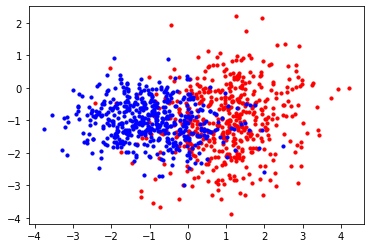

In [2]:
data = gen_non_linear_data()

2. Design SVM with different kernels.

In [3]:
# define kenrel functions
def linear_kernel(x1, x2):
    return np.dot(x1, x2)


def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p


def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))

In [4]:
import cvxopt

class SVM(object):
    """
    SVM w/ QP
    """

    def __init__(self, kernel='linear', C=1):
        if kernel == 'linear':
            self.kernel = linear_kernel
        elif kernel == 'polynomial':
            self.kernel = polynomial_kernel
        elif kernel == 'gaussian':
            self.kernel = gaussian_kernel
        else:
            raise NotImplementedError
        
        self.C = C
        if self.C is not None: 
            self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y.astype('double'), (1, n_samples))
        b = cvxopt.matrix(0.0)

        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))

        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Solve QP problem using cvxopt lib
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector for linear kernel
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

3. Test SVM

In [5]:
def plot_contour(X1_train, X2_train, clf, kernel_name):
    plt.scatter(clf.sv[:, 0], clf.sv[:, 1], c='green', s=45)
    plt.scatter(X1_train[:, 0], X1_train[:, 1], c='red', s=10)
    plt.scatter(X2_train[:, 0], X2_train[:, 1], c='blue', s=10)
    

    X1, X2 = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 2.5, 50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    plt.axis("tight")
    plt.title(kernel_name + ' kernel')
    plt.show()


def test_non_linear(data, kernel):
    X_train, y_train, X_test, y_test = data

    clf = SVM(kernel=kernel, C=1)    # change kernel here
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))
    print("Test accuracy: %.4f%%" % (correct / len(y_predict)))

    plot_contour(X_train[y_train == 1], X_train[y_train == -1], clf, kernel_name=kernel)

     pcost       dcost       gap    pres   dres
 0: -4.1681e+02 -2.1832e+03  1e+04  3e+00  3e-14
 1: -2.7886e+02 -1.5033e+03  2e+03  4e-01  2e-14
 2: -2.5712e+02 -4.4287e+02  2e+02  6e-03  1e-14
 3: -3.0022e+02 -3.4961e+02  5e+01  1e-03  1e-14
 4: -3.0688e+02 -3.4206e+02  4e+01  9e-04  1e-14
 5: -3.1144e+02 -3.3609e+02  3e+01  5e-04  1e-14
 6: -3.1484e+02 -3.3182e+02  2e+01  3e-04  1e-14
 7: -3.1754e+02 -3.2837e+02  1e+01  2e-04  1e-14
 8: -3.1824e+02 -3.2752e+02  9e+00  1e-04  1e-14
 9: -3.1924e+02 -3.2610e+02  7e+00  7e-05  1e-14
10: -3.2053e+02 -3.2454e+02  4e+00  3e-05  1e-14
11: -3.2133e+02 -3.2361e+02  2e+00  1e-05  1e-14
12: -3.2174e+02 -3.2311e+02  1e+00  6e-06  2e-14
13: -3.2231e+02 -3.2247e+02  2e-01  3e-16  2e-14
14: -3.2239e+02 -3.2239e+02  4e-03  3e-15  2e-14
15: -3.2239e+02 -3.2239e+02  1e-04  6e-16  2e-14
Optimal solution found.
324 support vectors out of 800 points
171 out of 200 predictions correct
Test accuracy: 0.8550%


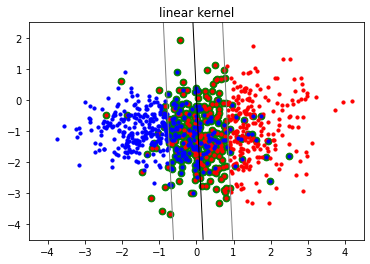

In [6]:
test_non_linear(data, 'linear')

     pcost       dcost       gap    pres   dres
 0: -3.6506e+02 -2.0205e+03  1e+04  3e+00  1e-12
 1: -2.4363e+02 -1.2841e+03  1e+03  2e-01  8e-13
 2: -2.3848e+02 -6.7743e+02  5e+02  6e-02  6e-13
 3: -2.6183e+02 -3.6219e+02  1e+02  1e-02  5e-13
 4: -2.7845e+02 -3.2439e+02  5e+01  4e-03  4e-13
 5: -2.8434e+02 -3.1190e+02  3e+01  2e-03  5e-13
 6: -2.8816e+02 -3.0423e+02  2e+01  9e-04  5e-13
 7: -2.8992e+02 -3.0066e+02  1e+01  5e-04  5e-13
 8: -2.9172e+02 -2.9721e+02  6e+00  2e-04  5e-13
 9: -2.9329e+02 -2.9465e+02  1e+00  3e-05  6e-13
10: -2.9368e+02 -2.9411e+02  4e-01  9e-06  6e-13
11: -2.9383e+02 -2.9390e+02  6e-02  1e-06  6e-13
12: -2.9385e+02 -2.9387e+02  2e-02  3e-07  6e-13
13: -2.9386e+02 -2.9386e+02  2e-03  8e-09  7e-13
14: -2.9386e+02 -2.9386e+02  2e-05  8e-11  6e-13
Optimal solution found.
301 support vectors out of 800 points
172 out of 200 predictions correct
Test accuracy: 0.8600%


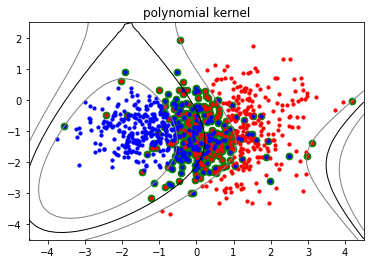

In [7]:
test_non_linear(data, 'polynomial')

     pcost       dcost       gap    pres   dres
 0: -3.9338e+02 -2.1382e+03  1e+04  3e+00  9e-15
 1: -2.5931e+02 -1.4511e+03  2e+03  3e-01  6e-15
 2: -2.6194e+02 -4.2203e+02  2e+02  1e-02  5e-15
 3: -3.0774e+02 -3.6184e+02  6e+01  4e-03  5e-15
 4: -3.1720e+02 -3.5096e+02  3e+01  2e-03  6e-15
 5: -3.2495e+02 -3.4227e+02  2e+01  9e-04  6e-15
 6: -3.2796e+02 -3.3881e+02  1e+01  5e-04  6e-15
 7: -3.3013e+02 -3.3637e+02  6e+00  3e-04  5e-15
 8: -3.3201e+02 -3.3433e+02  2e+00  7e-05  6e-15
 9: -3.3249e+02 -3.3377e+02  1e+00  2e-05  6e-15
10: -3.3280e+02 -3.3343e+02  6e-01  4e-06  7e-15
11: -3.3308e+02 -3.3314e+02  6e-02  4e-07  6e-15
12: -3.3311e+02 -3.3311e+02  5e-03  2e-08  6e-15
13: -3.3311e+02 -3.3311e+02  1e-04  3e-10  6e-15
Optimal solution found.
357 support vectors out of 800 points
173 out of 200 predictions correct
Test accuracy: 0.8650%


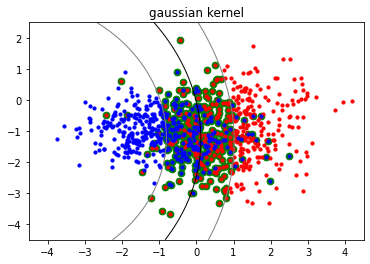

In [8]:
test_non_linear(data, 'gaussian')